In [ ]:
!pip install keras-tuner

In [ ]:
import tensorflow as tf
import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

In [ ]:
print(keras.__version__)

2.15.0


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [ ]:
y_test[2405][0]

3

## 1. 틀린 Label 22개 시각화 및 수정

In [ ]:
# labelerrors.com에서 확인한 잘못된 레이블의 ID
incorrect_ids = [2405, 6877, 8058, 2532, 7657, 1969, 2804, 6792, 1227, 5191, 5690, 1718, 2592, 4794, 5960, 165, 9227, 5632, 9352, 7846, 6966, 5468]

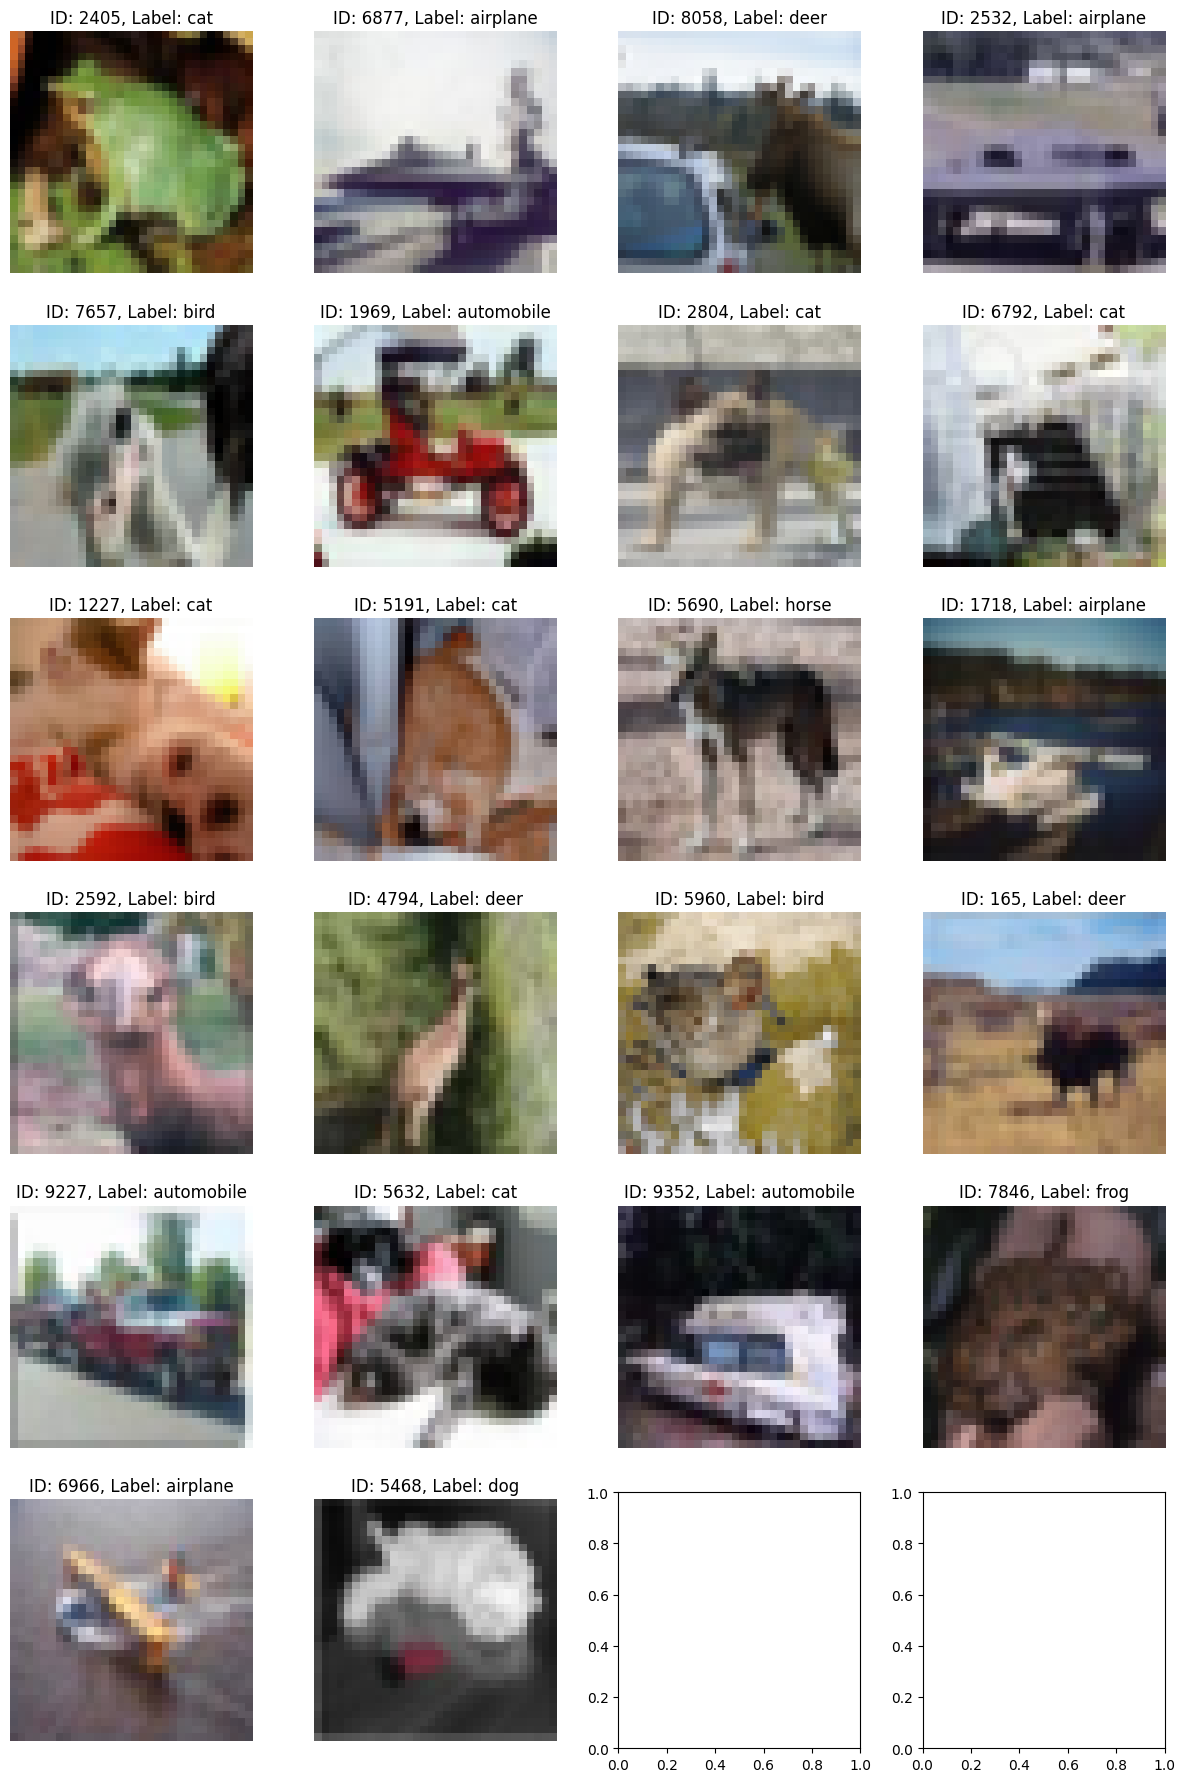

In [ ]:
fig, axs = plt.subplots(6, 4, figsize=(12, 18))  # 6x4 그리드, 전체 그림의 크기는 12x18

# 잘못된 레이블이 있는지 확인하고 시각화
for i, idx in enumerate(incorrect_ids):
    img = x_test[idx]
    label = y_test[idx][0]  # CIFAR-10은 레이블이 [label] 형태로 되어 있으므로 [0]을 사용하여 추출
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # 각 이미지를 그리드에 배치
    ax = axs[i // 4, i % 4]  # 행, 열 인덱스 계산
    ax.imshow(img)
    ax.set_title(f'ID: {idx}, Label: {class_names[label]}')
    ax.axis('off')

# 그리드 간 간격 조절
plt.tight_layout()

# 이미지 출력
plt.show()

In [ ]:
# label을 수정하는 함수
def fix_label(dataset, idx, new_label):
    dataset[idx][0] = new_label

# 잘못된 레이블 수정 (문자열로 수정)
new_labels = ['frog', 'ship', 'horse', 'automobile', 'horse', 'truck', 'dog', 'truck', 'dog', 'dog', 'deer', 'ship', 'deer', 'bird', 'cat', 'bird', 'truck', 'dog', 'truck', 'cat', 'ship', 'cat']
for i, idx in enumerate(incorrect_ids):
    label_idx = class_names.index(new_labels[i])  # 문자열을 인덱스로 변환
    fix_label(y_test, idx, label_idx)

# 수정된 레이블 확인 (문자열로 출력)
for idx in incorrect_ids:
    label = y_test[idx][0]
    print(f'ID: {idx}, New Label: {class_names[label]}')

ID: 2405, New Label: frog
ID: 6877, New Label: ship
ID: 8058, New Label: horse
ID: 2532, New Label: automobile
ID: 7657, New Label: horse
ID: 1969, New Label: truck
ID: 2804, New Label: dog
ID: 6792, New Label: truck
ID: 1227, New Label: dog
ID: 5191, New Label: dog
ID: 5690, New Label: deer
ID: 1718, New Label: ship
ID: 2592, New Label: deer
ID: 4794, New Label: bird
ID: 5960, New Label: cat
ID: 165, New Label: bird
ID: 9227, New Label: truck
ID: 5632, New Label: dog
ID: 9352, New Label: truck
ID: 7846, New Label: cat
ID: 6966, New Label: ship
ID: 5468, New Label: cat


In [ ]:
# 첫번째 개구리 사진 label 수정 결과 확인
class_names[y_test[2405][0]]

'frog'

## ㄴ Rubric 2.  잘못 들어간 test label들을 수정하였는가? O

## 2. 모델 설계

In [ ]:
X_train = x_train.reshape(-1,32, 32, 3)  # reshaping for convnet
X_test = x_test.reshape(-1,32,32,3)
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
print(X_train.shape)

(50000, 32, 32, 3)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)
print(X_train.shape)

(40000, 32, 32, 3)


In [ ]:
class DeepTuner(kt.Tuner):
    def run_trial(self, trial, X, y, validation_data, **fit_kwargs):
        model = self.hypermodel.build(trial.hyperparameters)
        model.fit(X, y, batch_size=trial.hyperparameters.Choice(
            'batch_size', [16, 32]), **fit_kwargs)


        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        return {name: value for name, value in zip(
            model.metrics_names,
            eval_scores)}

In [ ]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=X_train.shape[1:], name='inputs'))

    # 첫 번째 Conv2D 레이어
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    # AveragePooling2D, BatchNormalization
    model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())

    # 두 번째 Conv2D 레이어
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    # AveragePooling2D, BatchNormalization
    model.add(tf.keras.layers.AveragePooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.BatchNormalization())

    model.add(tf.keras.layers.Flatten())
    # units 256 고정된 Dense layer
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    # Dropout layer 추가
    model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', 0.0, 0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(10, activation='softmax', name='outputs'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
my_keras_tuner = DeepTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('accuracy', 'max'),
        max_trials=10,
        seed=42),
    hypermodel=build_model,
    overwrite=True,
    project_name='my_keras_tuner')


my_keras_tuner.search(
    X_train, y_train, validation_data=(X_val, y_val), epochs=3)


Trial 10 Complete [00h 00m 20s]
accuracy: 0.6603000164031982

Best accuracy So Far: 0.6765999794006348
Total elapsed time: 00h 05m 46s


In [ ]:
best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]
model = build_model(best_hps)
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 average_pooling2d_22 (Aver  (None, 15, 15, 32)        0         
 agePooling2D)                                                   
                                                                 
 batch_normalization_22 (Ba  (None, 15, 15, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_23 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 average_pooling2d_23 (Aver  (None, 6, 6, 64)          0         
 agePooling2D)                                                   
                                                     

## ㄴ Rubric 1. 그림에 맞게 딥러닝 모델을 잘 설계하였는가? O

In [ ]:
from google.colab import drive
drive.mount('/content/drive2')

Mounted at /content/drive2


In [ ]:
path = '/content/drive2/My Drive/Aiffel Project/mlops/model'
model.save(path)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

interpreter = tf.lite.Interpreter(model_content=tflite_model)

signatures = interpreter.get_signature_list()
print(signatures)


{'serving_default': {'inputs': ['inputs'], 'outputs': ['outputs']}}


In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [ ]:
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)